# Visualising particle density

How to choose good density values for plotting?

**Problem:** Often, the [dynamic range](https://en.wikipedia.org/wiki/Dynamic_range) of particle density is very large. This is because some particles travel far away from the main group(s) and hence will lead to very low density values far away from the main signal. At the same time, the largest part of particles may stay closely together and hence make it difficult to discern any spatial structure there.

**Solution:** In general, there is no perfect solution for all situations. But there's two aspects which we need to control for making good use of particle density maps — thresholds and color mappings.

## But let's first load some data.

In [1]:
import numpy as np
import re
import xarray as xr

import cmocean

from pathlib import Path
from matplotlib.cm import ScalarMappable
from shapely.geometry import Polygon

In [2]:
output_path = '/gxfs_work1/geomar/smomw523/master-thesis/output_data/ROMS_child'#INALT20.L46-KFS119'


In [3]:
traj_files = sorted(Path(output_path).glob("Column_backwards_test_1500_20090301_RT-42_N-1000000_seed-12345.nc"))
traj_files[0].name

'Column_backwards_test_1500_20090301_RT-42_N-1000000_seed-12345.nc'

In [4]:
%%time

#ds = xr.concat(map(read_traj_file, traj_files), dim="traj");
#ds = ds.set_coords(["year", "release_zone"])
ds = xr.open_dataset(traj_files[0], chunks={"obs": 400, "traj": 2_000, })
display(ds)
print(ds.nbytes / 1e9, "GiB")

<xarray.Dataset>
Dimensions:     (traj: 1000000, obs: 46)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 dask.array<chunksize=(2000, 46), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(2000, 46), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(2000, 46), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(2000, 46), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(2000, 46), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

1.84 GiB
CPU times: user 41.9 ms, sys: 10.6 ms, total: 52.5 ms
Wall time: 172 ms


## Some (non-ideal) visualisation

First, we need Dask, because this may be a lot of data.

Then, let's load xhistogram and chose how many bins in lat / lon we want.

In [5]:
from xhistogram.xarray import histogram as xhist

In [6]:
# With the 20 regions which all only populate a small part of the North Sea, we need lots of resolution:
num_lon = 100
num_lat = 100

And calculate the target grid.

In [7]:
lon_min = ds.lon.min().persist().data[()]
lon_max = ds.lon.max().persist().data[()]
lat_min = ds.lat.min().persist().data[()]
lat_max = ds.lat.max().persist().data[()]

This will take some time:

In [8]:
%%time

lon_min = lon_min.compute()
lon_max = lon_max.compute()
lat_min = lat_min.compute()
lat_max = lat_max.compute()

CPU times: user 1.47 ms, sys: 769 µs, total: 2.24 ms
Wall time: 1.85 ms


In [9]:
dlon = (lon_max - lon_min) / (num_lon - 3)
dlat = (lat_max - lat_min) / (num_lat - 3)

In [10]:
lons = np.arange(lon_min - dlon, lon_max + 2 * dlon, dlon)
lats = np.arange(lat_min - dlat, lat_max + 2 * dlat, dlat)

In [11]:
heat_map = xhist(ds.lon, ds.lat, bins=[lons, lats], dim=["traj", ])
heat_map

<xarray.DataArray 'histogram_lon_lat' (obs: 46, lon_bin: 99, lat_bin: 99)>
dask.array<sum-aggregate, shape=(46, 99, 99), dtype=int64, chunksize=(46, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * lon_bin  (lon_bin) float64 7.554 7.568 7.581 7.594 ... 8.836 8.849 8.862
  * lat_bin  (lat_bin) float64 -23.8 -23.78 -23.77 ... -22.72 -22.71 -22.7
Dimensions without coordinates: obs

In [12]:
%%time

heat_map = heat_map.where(heat_map > 0)
heat_map = heat_map.compute()

CPU times: user 5.7 s, sys: 692 ms, total: 6.39 s
Wall time: 1.05 s



As we don't have a lot of particles (yet), let's average over the last 200 obs steps and show the heat map:

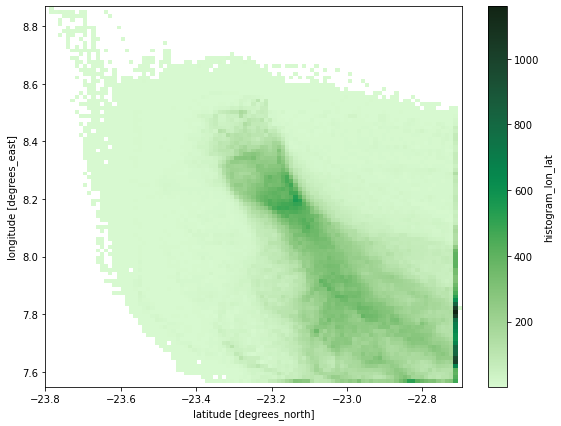

In [13]:
heat_map.isel(obs=slice(-200, None)).mean("obs").plot(size=7, cmap=cmocean.cm.algae)

Hardly readable!

What about a log-scale?

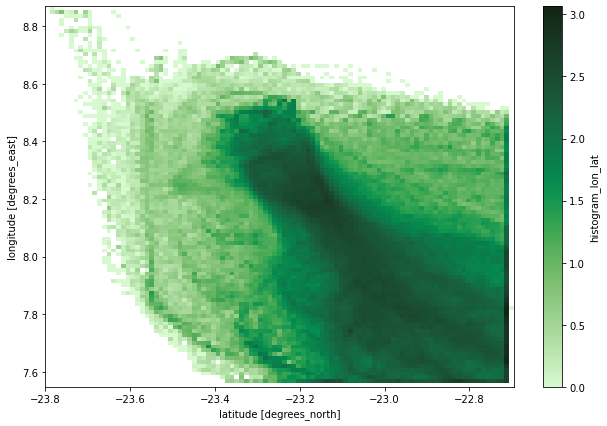

In [14]:
np.log10(heat_map.isel(obs=slice(-200, None)).mean("obs")).plot(size=7, cmap=cmocean.cm.algae)

Better.  (This could be already a solution for some cases if we tweak the colors a bit.)

But let's see if we can control the 3 orders of magnitude any better.

## Quantiles

To have a linear distribution of colors, we can transform the heat map to quantiles.

First, let's just extract the final 200 obs steps so we don't need to handle the obs dimension any more.

In [15]:
heat_map = heat_map.isel(obs=5)#slice(-200, None)).mean("obs")
heat_map

<xarray.DataArray 'histogram_lon_lat' (lon_bin: 99, lat_bin: 99)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon_bin  (lon_bin) float64 7.554 7.568 7.581 7.594 ... 8.836 8.849 8.862
  * lat_bin  (lat_bin) float64 -23.8 -23.78 -23.77 ... -22.72 -22.71 -22.7

What's the distribution?

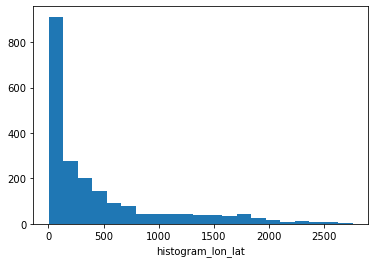

In [16]:
heat_map.plot.hist(bins=21);

In [17]:
quants = heat_map.quantile(q=np.arange(0, 1, 0.01))

In [18]:
import scipy.integrate as integrate

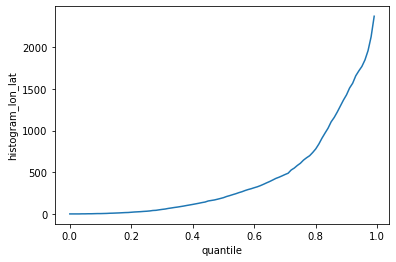

In [19]:
quants.plot()

In [20]:
quants_sum = []
for i in [int(j) for j in np.linspace(0,100,101)]:
    a= quants[i:100].sum()/quants.sum()
    quants_sum.append(a)
quants_sum=np.asarray(quants_sum)

In [21]:
quants_sum

array([1.        , 0.99997711, 0.99995421, 0.99993132, 0.99990843,
       0.99986264, 0.99981685, 0.99974817, 0.99967949, 0.99958792,
       0.99947346, 0.99935899, 0.99922163, 0.99906138, 0.99885534,
       0.99862641, 0.99836199, 0.99806438, 0.99772098, 0.99733179,
       0.99691971, 0.99643896, 0.99588952, 0.99529429, 0.99465328,
       0.99394359, 0.99318239, 0.99234404, 0.99138275, 0.99037545,
       0.98923697, 0.98797784, 0.98661638, 0.98508986, 0.98344155,
       0.98165587, 0.97975688, 0.97771938, 0.97554452, 0.97320941,
       0.9707271 , 0.96809437, 0.9653014 , 0.96234817, 0.95921386,
       0.95593371, 0.95236237, 0.94865366, 0.94480759, 0.94076099,
       0.93649987, 0.93201279, 0.92721116, 0.92216915, 0.91685792,
       0.91129486, 0.90543419, 0.8993217 , 0.89288663, 0.88617891,
       0.87924226, 0.87203089, 0.86456769, 0.85678399, 0.84863399,
       0.84009481, 0.83118591, 0.82186241, 0.81210988, 0.80203686,
       0.79159754, 0.78076903, 0.76959095, 0.75752804, 0.74493

In [22]:
np.min(np.where(quants_sum<0.95))

47

So what if we transform the values to quantiles?

(Really understanding what's happening in the next cell is a good Xarray exercise. :) )

In [23]:
heat_map_transformed = quants.coords["quantile"].where(heat_map > quants).max("quantile")

In [24]:
import matplotlib.pyplot as plt

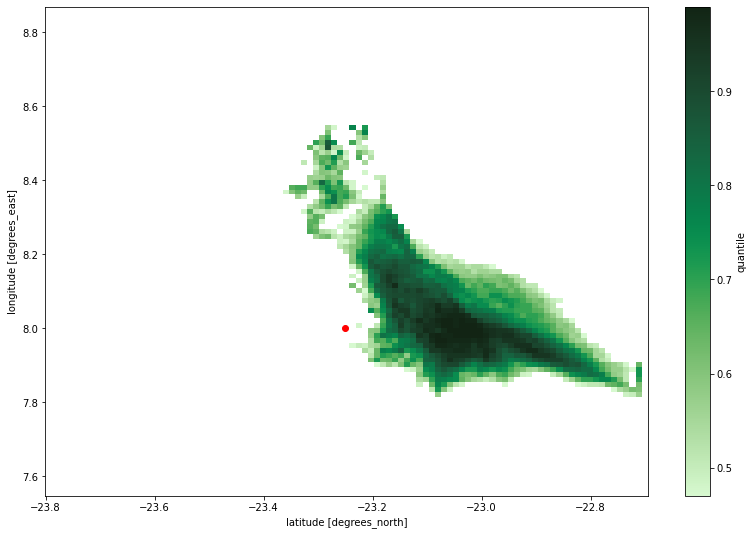

In [25]:
heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100)).plot(size=9, cmap=cmocean.cm.algae) #95% Quantil
plt.scatter(-23.25,8,color='red')

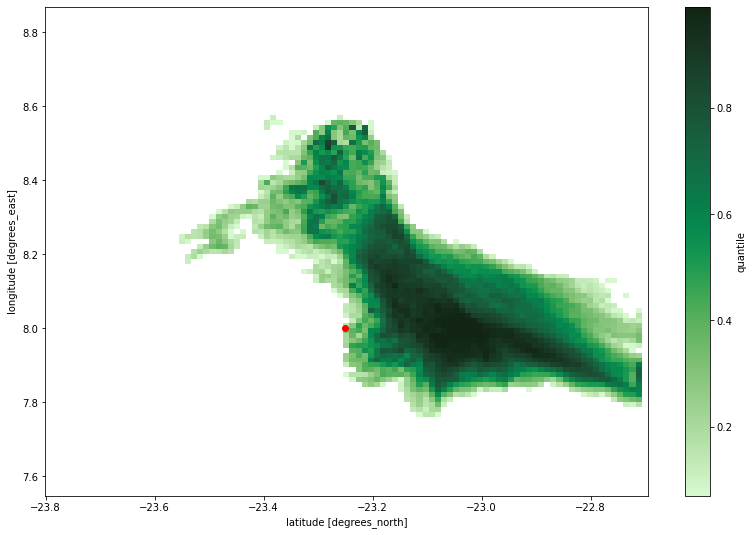

In [26]:
heat_map_transformed.where(heat_map_transformed>0.05).plot(size=9, cmap=cmocean.cm.algae)
plt.scatter(-23.25,8,color='red')
plt.contour(heat_map_transformed,colors='red')

In [27]:
plt.rcParams.update({'font.size': 18})

Text(0.5, 1.0, '100000 particles')

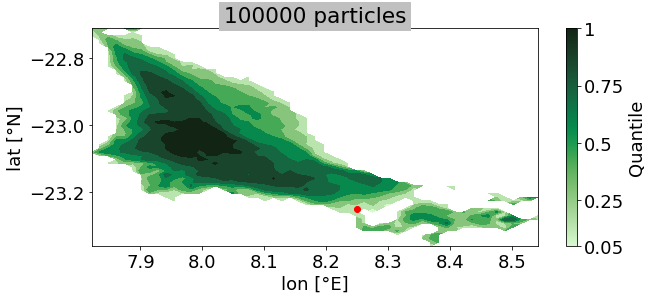

In [28]:
plt.figure(figsize=(10,4))
cf=plt.contourf(heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).lon_bin,
                heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).lat_bin,
                heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).T,
                vmin=(np.min(np.where(quants_sum<0.95))/100),vmax=1, cmap=cmocean.cm.algae)
#cs=plt.contour(heat_map_transformed.lon_bin,heat_map_transformed.lat_bin,heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100)).T,vmin=(np.min(np.where(quants_sum<0.95))/100),vmax=1,colors='red',levels=10)
cb=plt.colorbar(ScalarMappable(norm=cf.norm, cmap=cf.cmap),label='Quantile',ticks=[(np.min(np.where(quants_sum<0.95))/100),
                                                                                   (np.min(np.where(quants_sum<0.95))/100)+((4/19)*(1-(np.min(np.where(quants_sum<0.95))/100))),
                                                                                   (np.min(np.where(quants_sum<0.95))/100)+((9/19)*(1-(np.min(np.where(quants_sum<0.95))/100))),
                                                                                   (np.min(np.where(quants_sum<0.95))/100)+((14/19)*(1-(np.min(np.where(quants_sum<0.95))/100))),
                                                                                   1])
cb.set_ticklabels(['0.05','0.25','0.5','0.75','1'])
plt.scatter(8.25,-23.25,color='red')
plt.xlabel('lon [°E]')
plt.ylabel('lat [°N]')
#plt.ylim([-24.5,-21.5])
#plt.yticks([-21.5,-22,-22.5,-23,-23.5,-24,-24.5])
#plt.xlim([4.5,9.5])
plt.title('100000 particles', backgroundcolor= 'silver')
#plt.savefig('how-many-particles/ROMS_0100000.png')

In [29]:
lattokm = np.linspace(0,(heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).lat_bin.max()-heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).lat_bin.min())*110.574,len(heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).lat_bin))
lontokm = np.linspace(0,(heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).lon_bin.max()-heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).lon_bin.min())*111.320*np.cos(heat_map_transformed.lat_bin.mean()* np.pi / 180),len(heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).lon_bin))

In [30]:
heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).min()

<xarray.DataArray 'quantile' ()>
array(0.47)

Text(0, 0.5, 'km')

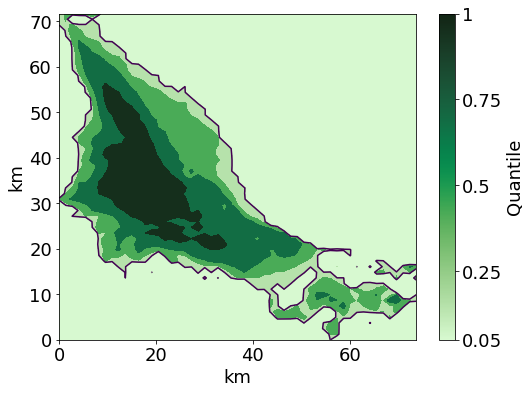

In [31]:
plt.figure(figsize=(8,6))
cf=plt.contourf(lontokm,lattokm,heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).fillna(0).T,vmin=(np.min(np.where(quants_sum<0.95))/100),vmax=1, cmap=cmocean.cm.algae)
cb=plt.colorbar(ScalarMappable(norm=cf.norm, cmap=cf.cmap),label='Quantile',ticks=[(np.min(np.where(quants_sum<0.95))/100),
                                                                                   (np.min(np.where(quants_sum<0.95))/100)+((4/19)*(1-(np.min(np.where(quants_sum<0.95))/100))),
                
                                                                                   (np.min(np.where(quants_sum<0.95))/100)+((9/19)*(1-(np.min(np.where(quants_sum<0.95))/100))),
                                                                                   (np.min(np.where(quants_sum<0.95))/100)+((14/19)*(1-(np.min(np.where(quants_sum<0.95))/100))),
                                                                                   1])
cl=plt.contour(lontokm,lattokm,heat_map_transformed.where(heat_map_transformed>(np.min(np.where(quants_sum<0.95))/100),drop=True).fillna(0).T,levels=[(np.min(np.where(quants_sum<0.95))/100)])
cb.set_ticklabels(['0.05','0.25','0.5','0.75','1'])
#plt.scatter(8.25,-23.25,color='red')
plt.xlabel('km')
plt.ylabel('km')
#plt.ylim([-24.5,-21.5])
#plt.yticks([-21.5,-22,-22.5,-23,-23.5,-24,-24.5])
#plt.xlim([4.5,9.5])
#plt.title('100000 particles');#, backgroundcolor= 'silver');
#plt.savefig('how-many-particles/ROMS_0100000.png')

In [32]:
import numpy as np
import matplotlib.pylab as plt

# Use Green's theorem to compute the area
# enclosed by the given contour.
def area(vs):
    a = 0
    x0,y0 = vs[0]
    for [x1,y1] in vs[1:]:
        dx = x1-x0
        dy = y1-y0
        a += 0.5*(y0*dx - x0*dy)
        x0 = x1
        y0 = y1
    return a

# Plot the data
levels = [(np.min(np.where(quants_sum<0.95))/100)]
#cs = plt.contour(X,Y,r,levels=levels)
#plt.clabel(cs, inline=1, fontsize=10)

# Get one of the contours from the plot.
for i in range(len(levels)):
    contour = cl.collections[i]
    complete_area = []
    for j in np.arange(len(contour.get_paths())):
        vs = contour.get_paths()[j].vertices
        # Compute area enclosed by vertices.
        a = np.abs(area(vs))
        complete_area.append(a)
    print("r = " + str(levels[i]) + ": a =" + str(np.sum(complete_area)))

plt.show()

r = 0.47: a =3452.3970827985136
